In [ ]:
!pip install nltk
!pip install streamlit
import nltk
nltk.download('punkt')

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import os
import librosa
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Conv3D, MaxPooling3D, LSTM, Input, concatenate
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import kagglehub
import streamlit as st
import librosa
from PIL import Image
from tensorflow import keras

# Preprocess Text

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NTI/final project NTI/train.csv")

# extract the text and labels
tweet = list(data['tweet'])
labels = list(data['class'])

######## Text Preprocessing Function ########

import nltk

# Download the 'stopwords' dataset
nltk.download('stopwords')

# Now, you can import and use stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# ... rest of your code ...

# add rt to remove retweet in dataset (noise)
stop_words.add("rt")

# remove html entity:
def remove_entity(raw_text):
    entity_regex = r"&[^\s;]+;"
    text = re.sub(entity_regex, "", raw_text)
    return text

# change the user tags
def change_user(raw_text):
    regex = r"@([^ ]+)"
    text = re.sub(regex, "user", raw_text)
    return text

# remove urls
def remove_url(raw_text):
    url_regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    text = re.sub(url_regex, '', raw_text)
    return text

# remove unnecessary symbols
def remove_noise_symbols(raw_text):
    text = raw_text.replace('"', '')
    text = text.replace("'", '')
    text = text.replace("!", '')
    text = text.replace("`", '')
    text = text.replace("..", '')
    return text

# remove stopwords
def remove_stopwords(raw_text):
    tokenize = nltk.word_tokenize(raw_text)
    text = [word for word in tokenize if not word.lower() in stop_words]
    text = " ".join(text)
    return text

# this function in to clean all the dataset by utilizing all the functions above
def preprocess(datas):
    clean = []
    # change the @xxx into "user"
    clean = [change_user(text) for text in datas]
    # remove emojis (specifically unicode emojis)
    clean = [remove_entity(text) for text in clean]
    # remove urls
    clean = [remove_url(text) for text in clean]
    # remove trailing stuff
    clean = [remove_noise_symbols(text) for text in clean]
    # remove stopwords
    clean = [remove_stopwords(text) for text in clean]

    return clean


clean_tweet = preprocess(tweet)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(clean_tweet, labels, test_size=0.2, random_state=42)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# tokenize the train and test dataset
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# vocabulary size (num of unique words) -> will be used in embedding layer
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
max_length = max(len(seq) for seq in X_train)

# to test an outlier case (if one of the test dataset has longer length)
for x in X_test:
    if len(x) > max_length:
        print(f"an outlier detected: {x}")

X_train = pad_sequences(X_train, maxlen = max_length)
X_test = pad_sequences(X_test, maxlen = max_length)

# preprocess Images

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ananthu017/emotion-detection-fer")

print("Path to dataset files:", path)

In [ ]:
import pathlib
data_dir = pathlib.Path("/root/.cache/kagglehub/datasets/ananthu017/emotion-detection-fer/versions/1/train")
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)
# classnames in the dataset specified
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt" ])
print(CLASS_NAMES)
# print length of class names
output_class_units = len(CLASS_NAMES)
print(output_class_units)

In [ ]:
data_dir2 = pathlib.Path("/root/.cache/kagglehub/datasets/ananthu017/emotion-detection-fer/versions/1/test")
batch_size = 64
img_height = 227
img_width = 227
STEPS_PER_EPOCH = np.ceil(image_count/batch_size)
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     target_size=(img_height, img_width), #Resizing the raw dataset
                                                     classes = list(CLASS_NAMES))
val_data_gen = image_generator.flow_from_directory(directory=str(data_dir2),
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     target_size=(img_height, img_width), #Resizing the raw dataset
                                                     classes = list(CLASS_NAMES))

# preprocess of audio

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("saniuzzamanrobin/ravdess-speech-all-audio-and-video")

print("Path to dataset files:", path)

In [ ]:
df='/root/.cache/kagglehub/datasets/saniuzzamanrobin/ravdess-speech-all-audio-and-video/versions/1'
vid_path = os.path.join(df, 'All Videos')
vid_files = os.listdir(vid_path)
print("Video Files:", vid_files)

In [ ]:
# Define the emotions present in the dataset
emotions = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}
# Paths to audio and video directories
audio_dir = "/root/.cache/kagglehub/datasets/saniuzzamanrobin/ravdess-speech-all-audio-and-video/versions/1/All Audios"
video_dir = "/root/.cache/kagglehub/datasets/saniuzzamanrobin/ravdess-speech-all-audio-and-video/versions/1/All Videos"

In [31]:
# Global lists for audio features and labels
audio_features = []
audio_labels = []
max_audio_frames = 180

def extract_audio_features(audio_dir):
    global audio_features, audio_labels  # Declare global variables

    # Loop through the audio directory
    for filename in os.listdir(audio_dir):
        if filename.endswith(".wav"):
            # Extract the emotion label from the filename
            emotion_label = emotions[filename.split("-")[2]]

            # Load the audio file
            audio_path = os.path.join(audio_dir, filename)
            # Load audio file using librosa
            audio, sr = librosa.load(audio_path)
            # Extract audio features using librosa
            mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20)
            # Append MFCC features and emotion label to the lists
            audio_features.append(mfcc.T)  # Transpose MFCC to have (num_frames, n_mfcc) shape
            audio_labels.append(emotion_label)

    # Apply padding or trimming to make audio features consistent in length
    for i in range(len(audio_features)):
        num_frames = audio_features[i].shape[0]
        if num_frames < max_audio_frames:
            # Padding: Add zeros to the end to match the desired length
            padding = np.zeros((max_audio_frames - num_frames, audio_features[i].shape[1]))
            audio_features[i] = np.vstack((audio_features[i], padding))
        elif num_frames > max_audio_frames:
            # Trimming: Remove extra frames to match the desired length
            audio_features[i] = audio_features[i][:max_audio_frames]

    # Convert the audio_features list to a numpy array
    audio_features = np.array(audio_features)

    return audio_features


In [ ]:
# Call the function to extract features and populate audio_labels
extract_audio_features(audio_dir)
# Encode emotion labels
label_encoder = LabelEncoder()
audio_labels_encoded = label_encoder.fit_transform(audio_labels)
audio_labels_onehot = to_categorical(audio_labels_encoded)

In [34]:
def extract_audio_features_from_file(audio_path, max_audio_frames=180):
    # Load the audio file using librosa
    audio, sr = librosa.load(audio_path)

    # Extract audio features (MFCCs)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)

    # If the number of frames is less than the required max_audio_frames, pad with zeros
    num_frames = mfcc.shape[1]  # Shape is (n_mfcc, num_frames), so we take the second dimension
    if num_frames < max_audio_frames:
        # Padding: Add zeros to the end to match the desired length
        padding = np.zeros((mfcc.shape[0], max_audio_frames - num_frames))
        mfcc = np.hstack((mfcc, padding))
    elif num_frames > max_audio_frames:
        # Trimming: Remove extra frames to match the desired lengthS
        mfcc = mfcc[:, :max_audio_frames]

    # Transpose the MFCCs to have the shape (num_frames, n_mfcc)
    mfcc = mfcc.T

    # Reshape to add a batch dimension (required for model prediction)
    mfcc = np.expand_dims(mfcc, axis=0)  # Shape will be (1, max_audio_frames, n_mfcc)

    return mfcc

# Preprocess Video

In [32]:
batch_size = 10
cnt = 0
video_features = []
video_labels = []

def extract_video_features(video_dir):
    import math  # Import the math module
    global cnt

    def exclude_frames(video_frames, frame_rate, exclude_duration=0.4):
        exclude_frames_start = math.ceil(frame_rate * exclude_duration)
        exclude_frames_end = math.floor(frame_rate * exclude_duration)
        return video_frames[exclude_frames_start:-exclude_frames_end]

    for filename in os.listdir(video_dir):  # Iterate directly through files in the directory
        if filename.endswith(".mp4"):
            # Extract the emotion label from the filename
            try:
                emotion_label = emotions[filename.split("-")[2]]
            except (IndexError, KeyError):
                print(f"Warning: Could not extract emotion label from filename: {filename}")
                continue  # Skip this file if emotion label extraction fails

            # Load the video file
            video_path = os.path.join(video_dir, filename)
            cap = cv2.VideoCapture(video_path)

            # Check if the video file was opened successfully
            if not cap.isOpened():
                print(f"Error: Could not open video file: {filename}")
                continue  # Skip this file if it cannot be opened

            # Calculate the frame rate of the video
            frame_rate = cap.get(cv2.CAP_PROP_FPS)
            frames = []
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break

                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                frame = frame[120:662, 400:912]
                frame = cv2.resize(frame, (80, 70))
                frames.append(frame)

            cap.release()

            # Exclude frames at the start and end of the video
            # Check if frames is not empty before calling exclude_frames
            if frames:
                frames = exclude_frames(frames, frame_rate, exclude_duration=0.4)
            else:
                print(f"Warning: No frames extracted for video: {filename}")
                continue  # Skip this file if no frames were extracted

            # Pad or truncate frames to have a consistent number of frames (20 frames)
            if len(frames) < 30:
                frames.extend([frames[-1]] * (30 - len(frames)))
            else:
                frames = frames[:30]

            if cnt % 100 == 0:
                print(cnt)
            cnt += 1
            video_features.append(frames)
            video_labels.append(emotion_label)

    video_features

In [33]:
extract_video_features(video_dir)
label_encoder = LabelEncoder()
video_labels_encoded = label_encoder.fit_transform(video_labels)
video_labels_onehot = to_categorical(video_labels_encoded)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400


In [35]:
import cv2
import numpy as np
import os
import math

def extract_video_features_from_file(video_path, target_size=(80, 70), num_frames=30):
    def exclude_frames(video_frames, frame_rate, exclude_duration=0.4):
        exclude_frames_start = math.ceil(frame_rate * exclude_duration)
        exclude_frames_end = math.floor(frame_rate * exclude_duration)
        return video_frames[exclude_frames_start:-exclude_frames_end]

    cap = cv2.VideoCapture(video_path)

    # Check if the video file was opened successfully
    if not cap.isOpened():
        print(f"Error: Could not open video file: {video_path}")
        return None

    # Calculate the frame rate of the video
    frame_rate = cap.get(cv2.CAP_PROP_FPS)
    frames = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert the frame to grayscale
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # Crop and resize the frame as per your model's input requirements
        frame = frame[120:662, 400:912]
        frame = cv2.resize(frame, target_size)
        # Normalize the frame (values between 0 and 1)
        frame = frame.astype(np.float32) / 255.0
        # Add the frame to the list of frames
        frames.append(frame)

    cap.release()

    # Exclude frames at the start and end of the video
    if frames:
        frames = exclude_frames(frames, frame_rate)

    # Pad or truncate frames to have a consistent number of frames (num_frames)
    if len(frames) < num_frames:
        frames.extend([frames[-1]] * (num_frames - len(frames)))  # Padding
    else:
        frames = frames[:num_frames]  # Trimming

    # Convert the list of frames to a numpy array with shape (num_frames, height, width, channels)
    video_features = np.array(frames)
    video_features = np.expand_dims(video_features, axis=-1)  # Add a channel dimension (for grayscale)

    # Add a batch dimension to the features (for prediction)
    video_features = np.expand_dims(video_features, axis=0)  # Shape: (1, num_frames, height, width, 1)

    return video_features


# ***Models***

In [36]:
# Load necessary NLTK data for text preprocessing
nltk.download('stopwords')
nltk.download('punkt')

# Register custom precision function
@tf.keras.utils.register_keras_serializable(package="custom_metrics")
def precision(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    tp = tf.reduce_sum(y_true * y_pred)
    predicted_positives = tf.reduce_sum(y_pred)
    return tp / (predicted_positives + tf.keras.backend.epsilon())

# Register custom recall function
@tf.keras.utils.register_keras_serializable(package="custom_metrics")
def recall(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    tp = tf.reduce_sum(y_true * y_pred)
    actual_positives = tf.reduce_sum(y_true)
    return tp / (actual_positives + tf.keras.backend.epsilon())

# Register custom F1-score function
@tf.keras.utils.register_keras_serializable(package="custom_metrics")
def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * (p * r) / (p + r + tf.keras.backend.epsilon())

# Load pre-trained models, passing all custom objects
content_moderation_model = tf.keras.models.load_model(
    '/content/drive/MyDrive/Colab Notebooks/NTI/final project NTI/model.keras',
    custom_objects={'f1': f1, 'precision': precision, 'recall': recall}
)

# emotion_detection_model = tf.keras.models.load_model(
#     '/content/image_moderation_model.keras',
#     custom_objects={'f1': f1, 'precision': precision, 'recall': recall}
# )

audio_moderation_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/NTI/final project NTI/audio_model.keras',custom_objects={'f1': f1, 'precision': precision, 'recall': recall})

video_moderation_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/NTI/final project NTI/video_model.keras',custom_objects={'f1': f1, 'precision': precision, 'recall': recall})

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# ***Predicton functions***

In [38]:
######## Text Moderation Prediction Function ########

def predict_text(model, tokenizer, text, max_length):
    cleaned_text = preprocess([text])  # preprocess expects a list
    sequences = tokenizer.texts_to_sequences(cleaned_text)
    padded_sequences = pad_sequences(sequences, maxlen=max_length)
    prediction = model.predict(padded_sequences)
    predicted_class = prediction.argmax(axis=-1)  # Get the index of the max log-probability
    return predicted_class


In [39]:
######## Emotion Detection Prediction Function ########
def predict_image(image_path, model):
  img = image.load_img(image_path, target_size=(227, 227))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = x / 255.0
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  predicted_class = np.argmax(classes[0])
  return CLASS_NAMES[predicted_class]

In [40]:
def predict_audio_emotion(audio_model, audio):
    # Get predictions from the individual audio model
    new_audio_features = extract_audio_features_from_file(audio)
    audio_prediction = audio_model.predict(new_audio_features)
    audio_predicted_emotion_index = np.argmax(audio_prediction, axis=1)
    audio_predicted_emotion = label_encoder.inverse_transform(audio_predicted_emotion_index)

    # Return the predicted emotion
    return audio_predicted_emotion[0]


In [41]:
def predict_video_emotion(video_model, video_path):
    # Extract video features
    new_video_features = extract_video_features_from_file(video_path)
    # Get predictions from the individual video model
    video_prediction = video_model.predict(new_video_features)

    # Use np.argmax with axis=-1 to get the index of the predicted emotion
    video_predicted_emotion_index = np.argmax(video_prediction, axis=-1)

    # Decode the predicted emotion index to the actual emotion label
    video_predicted_emotion = label_encoder.inverse_transform([video_predicted_emotion_index[0]])

    # Return the predicted emotion
    return video_predicted_emotion[0]



In [42]:
######## Combined Prediction Function ########
def combined_prediction(text, tokenizer, max_length , video , audio):
    moderation_result = predict_text(content_moderation_model, tokenizer, text, max_length)

    #emotion_result = predict_image(image_path, emotion_detection_model)

    audio_result = predict_audio_emotion(audio_moderation_model,audio,)

    video_result = predict_video_emotion(video_moderation_model,video)

    return pd.DataFrame({"Emotion from Text": moderation_result,  "Emotion from Video" : video_result , "Emotion from audio" : audio_result})


# **Test**

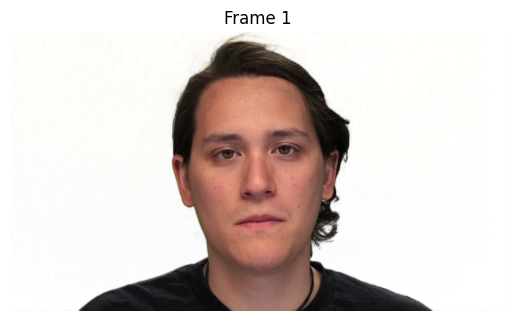

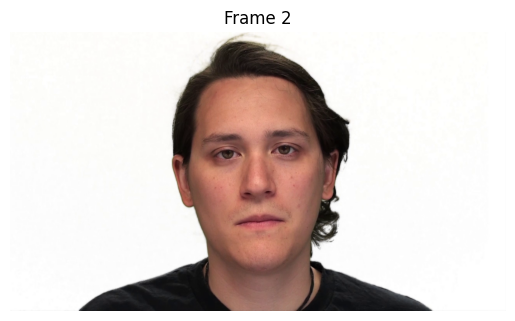

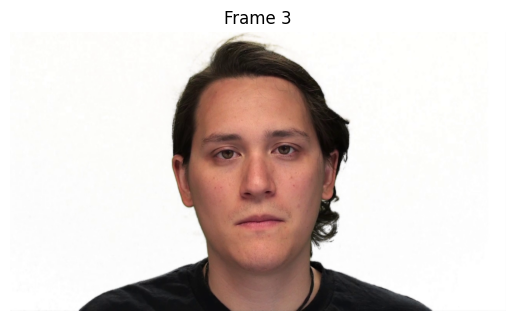

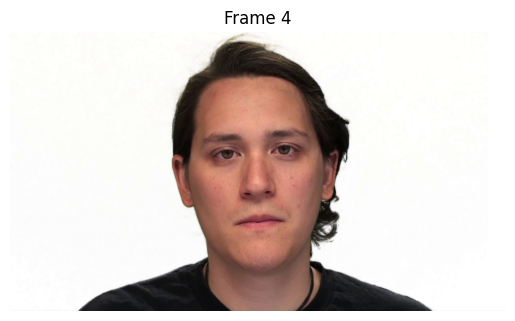

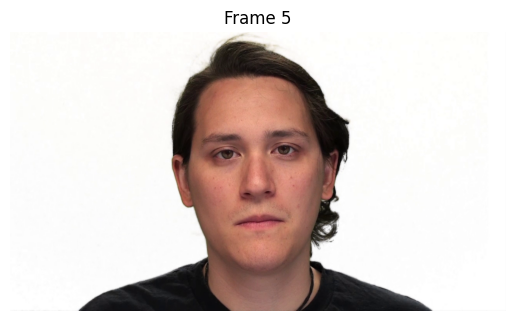

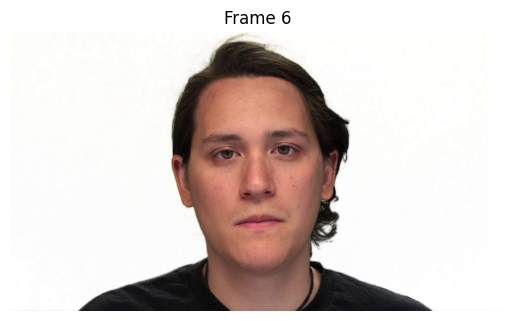

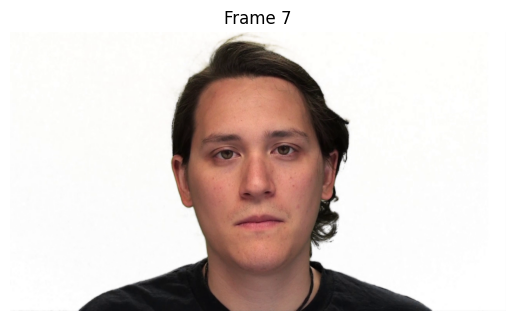

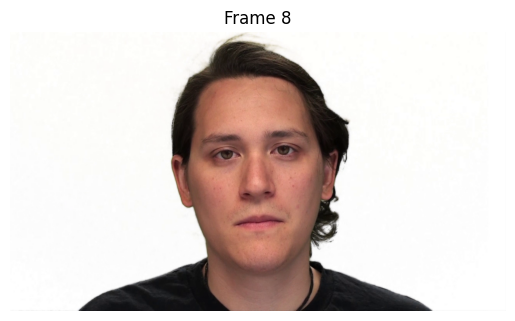

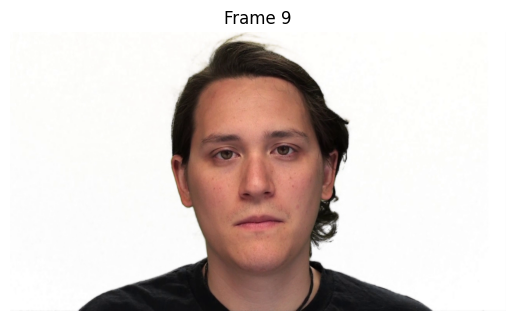

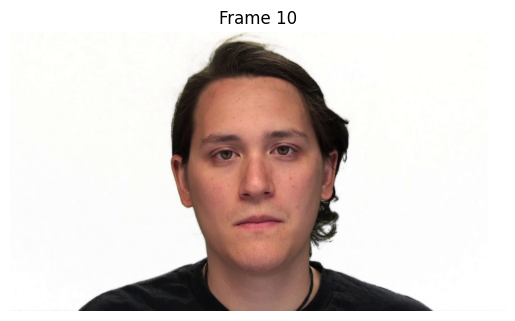

In [48]:
import cv2
import matplotlib.pyplot as plt

def visualize_video(video_path):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1

        # Convert BGR (OpenCV) to RGB (Matplotlib)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Show the frame using Matplotlib
        plt.imshow(frame_rgb)
        plt.title(f"Frame {frame_count}")
        plt.axis('off')
        plt.show()

        # Break after showing 10 frames (for example purposes)
        if frame_count == 10:
            break

    cap.release()

# Example usage
visualize_video('/content/01-01-05-01-01-02-23.mp4')

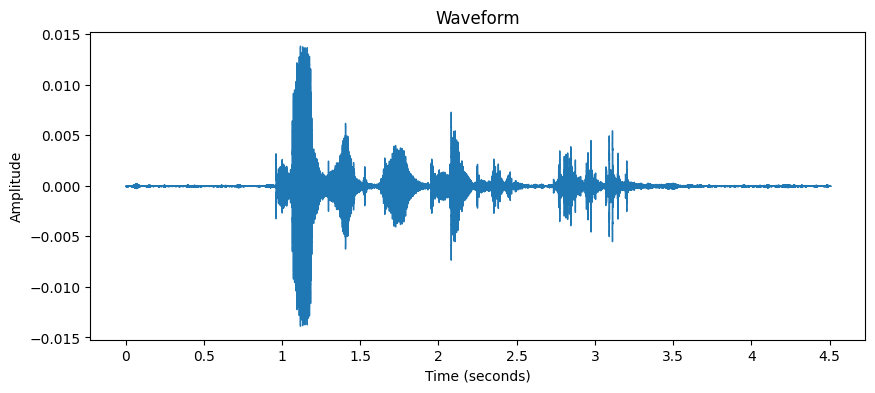

In [50]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

def visualize_audio_waveform(audio_path):
    # Load the audio file
    y, sr = librosa.load(audio_path)

    # Plot the waveform
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title('Waveform')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.show()

# Example usage
visualize_audio_waveform('/content/03-01-02-02-01-02-05 (1).wav')

In [54]:
from IPython.display import display, Video

def play_video_in_colab(video_path):
    # Display the video using HTML5 video player
    display(Video(video_path, embed=True))

# Example usage
play_video_in_colab('/content/01-01-05-01-01-02-23.mp4')

In [55]:
from IPython.display import display, Audio

def play_audio_in_colab(audio_path):
    # Display the audio player
    display(Audio(audio_path, autoplay=True))

# Example usage
play_audio_in_colab('/content/03-01-02-02-01-02-05 (1).wav')  # Replace with your audio file path


In [44]:
######## Example usage ########
text_input = "redneck in the White House // Moccasin Creek &#128077;&#128076;"
#image_path = "D:\\Courses\\Downloads\\emotins\\FearFul.jpg"
audio_path = "/content/03-01-02-02-01-02-05 (1).wav"
video_path = "/content/01-01-05-01-01-02-23.mp4"
result = combined_prediction(text_input,tokenizer, max_length,video_path,audio_path)
print(result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step
   Emotion from Text Emotion from Video Emotion from audio
0                  0              angry               calm


# ***Dashboard***

In [ ]:
# واجهة الداشبورد
st.title("Emotion Prediction Dashboard")

# اختيار نوع المدخل
input_type = st.selectbox("Select Input Type", ["Text", "Image", "Video", "Audio"])

if input_type == "Text":
    text_input = st.text_area("Enter Text:")
    if st.button("Predict Emotion"):
        if text_input:
            prediction = predict_text(text_input)
            st.success(f"Predicted Emotion: {prediction}")

elif input_type == "Image":
    image_file = st.file_uploader("Upload Image", type=["jpg", "jpeg", "png"])
    if st.button("Predict Emotion"):
        if image_file is not None:
            image = Image.open(image_file)
            st.image(image, caption='Uploaded Image', use_column_width=True)
            prediction = predict_image(image)
            st.success(f"Predicted Emotion: {prediction}")

elif input_type == "Video":
    video_file = st.file_uploader("Upload Video", type=["mp4"])
    if st.button("Predict Emotion"):
        if video_file is not None:
            st.video(video_file)
            prediction = predict_video_emotion(video_file)
            st.success(f"Predicted Emotion: {prediction}")

elif input_type == "Audio":
    audio_file = st.file_uploader("Upload Audio", type=["mp3"])
    if st.button("Predict Emotion"):
        if audio_file is not None:
            st.audio(audio_file)
            prediction = predict_audio_emotion(audio_file)
            st.success(f"Predicted Emotion: {prediction}")


In [45]:
# إنشاء ملف app.py وكتابة الكود فيه
code = """
import streamlit as st
from PIL import Image

# واجهة الداشبورد
st.title("Emotion Prediction Dashboard")

# اختيار نوع المدخل
input_type = st.selectbox("Select Input Type", ["Text", "Image", "Video", "Audio"])

if input_type == "Text":
    text_input = st.text_area("Enter Text:")
    if st.button("Predict Emotion"):
        if text_input:
            prediction = predict_emotion_text(text_input)
            st.success(f"Predicted Emotion: {prediction}")

elif input_type == "Image":
    image_file = st.file_uploader("Upload Image", type=["jpg", "jpeg", "png"])
    if st.button("Predict Emotion"):
        if image_file is not None:
            image = Image.open(image_file)
            st.image(image, caption='Uploaded Image', use_column_width=True)
            prediction = predict_emotion_image(image)
            st.success(f"Predicted Emotion: {prediction}")

elif input_type == "Video":
    video_file = st.file_uploader("Upload Video", type=["mp4"])
    if st.button("Predict Emotion"):
        if video_file is not None:
            st.video(video_file)
            prediction = predict_emotion_video(video_file)
            st.success(f"Predicted Emotion: {prediction}")

elif input_type == "Audio":
    audio_file = st.file_uploader("Upload Audio", type=["mp3"])
    if st.button("Predict Emotion"):
        if audio_file is not None:
            st.audio(audio_file)
            prediction = predict_emotion_audio(audio_file)
            st.success(f"Predicted Emotion: {prediction}")
"""

# كتابة الكود إلى الملف
with open('app.py', 'w') as f:
    f.write(code)

In [47]:
!pip install pyngrok
from pyngrok import ngrok

# استبدلي YOUR_AUTHTOKEN برمز المصادقة الخاص بك
ngrok.set_auth_token("2o5ZAWUPrVkrY64tg0VjtrBdepP_6FgRkgMtES8qPVpa1CWPJ")


ModuleNotFoundError: No module named 'pyngrok'

In [ ]:
# تثبيت pyngrok
#!pip install pyngrok

# تثبيت authtoken
from pyngrok import ngrok
ngrok.set_auth_token("2o5ZAWUPrVkrY64tg0VjtrBdepP_6FgRkgMtES8qPVpa1CWPJ")

# إنشاء ملف app.py
code = """
import streamlit as st
from PIL import Image

# تعريف وظائف التنبؤ (استبدلي هذه الوظائف بما لديك)
def predict_emotion_text(text):
    return "Happy"  # مثال

def predict_emotion_image(image):
    return "Surprised"  # مثال

def predict_emotion_video(video):
    return "Neutral"  # مثال

def predict_emotion_audio(audio):
    return "Sad"  # مثال

# واجهة الداشبورد
st.title("Emotion Prediction Dashboard")

# اختيار نوع المدخل
input_type = st.selectbox("Select Input Type", ["Text", "Image", "Video", "Audio"])

if input_type == "Text":
    text_input = st.text_area("Enter Text:")
    if st.button("Predict Emotion"):
        if text_input:
            prediction = predict_emotion_text(text_input)
            st.success(f"Predicted Emotion: {prediction}")

elif input_type == "Image":
    image_file = st.file_uploader("Upload Image", type=["jpg", "jpeg", "png"])
    if st.button("Predict Emotion"):
        if image_file is not None:
            image = Image.open(image_file)
            st.image(image, caption='Uploaded Image', use_column_width=True)
            prediction = predict_emotion_image(image)
            st.success(f"Predicted Emotion: {prediction}")

elif input_type == "Video":
    video_file = st.file_uploader("Upload Video", type=["mp4"])
    if st.button("Predict Emotion"):
        if video_file is not None:
            st.video(video_file)
            prediction = predict_emotion_video(video_file)
            st.success(f"Predicted Emotion: {prediction}")

elif input_type == "Audio":
    audio_file = st.file_uploader("Upload Audio", type=["mp3"])
    if st.button("Predict Emotion"):
        if audio_file is not None:
            st.audio(audio_file)
            prediction = predict_emotion_audio(audio_file)
            st.success(f"Predicted Emotion: {prediction}")
"""

# كتابة الكود إلى الملف
with open('app.py', 'w') as f:
    f.write(code)

# تشغيل Streamlit
#!streamlit run app.py &

# Modified code: using connect method with tunnel configuration
tunnel = ngrok.connect(addr="8501", proto="http", bind_tls=True)
# or: tunnel = ngrok.connect(8501, "http")
public_url = tunnel.public_url
print("Access the dashboard here:", public_url)
